In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Use GPU:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tensorflow as tf
import keras

tf.test.gpu_device_name()

''

Install StellarGraph:

In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 KB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.4 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.calibration import expected_calibration_error, plot_reliability_diagram
from stellargraph.calibration import IsotonicCalibration, TemperatureCalibration

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
from  stellargraph import StellarGraph
import pandas as pd


%matplotlib inline

Import data and split between years to predict and years to train:

In [ ]:
import random
import numpy as np
from  stellargraph import StellarGraph
import pandas as pd

#load the data
author_codes = np.load("/content/drive/MyDrive/scopus/data_scopus/author_codes.npy", allow_pickle = True)
affiliations = np.load("/content/drive/MyDrive/scopus/data_scopus/affiliations.npy", allow_pickle = True)
deg = np.load("/content/drive/MyDrive/scopus/data_scopus/deg.npy",allow_pickle = True)
har_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/har_cen.npy",allow_pickle = True)
deg_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/deg_cen.npy",allow_pickle = True)
clos_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/clos_cen.npy",allow_pickle = True)
bet_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/bet_cen.npy",allow_pickle = True)
load_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/load_cen.npy",allow_pickle = True)
pagerank = np.load("/content/drive/MyDrive/scopus/data_scopus/pagerank.npy",allow_pickle = True)
nodes_index = np.load("/content/drive/MyDrive/scopus/data_scopus/nodes_index.npy",allow_pickle = True)

source = np.load("/content/drive/MyDrive/scopus/data_scopus/source.npy",allow_pickle = True)
target = np.load("/content/drive/MyDrive/scopus/data_scopus/target.npy",allow_pickle = True)
years = np.load("/content/drive/MyDrive/scopus/data_scopus/years.npy",allow_pickle = True)
collabs = np.load("/content/drive/MyDrive/scopus/data_scopus/collabs.npy",allow_pickle = True)
edge_load_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/edge_load_cen.npy",allow_pickle = True)


source_train = []
target_train = []
years_train = []
collabs_train = []
edge_load_cen_train = []

source_test = []
target_test = []
years_test = []
collabs_test = []
edge_load_cen_test = []

p_size = 3  #the higher it is the less edges we take
j = 1
for i in range(len(years)):
  if(years[i] == 2016):
    years_test.append(years[i])
    source_test.append(source[i])
    target_test.append(target[i])
    collabs_test.append(collabs[i])
    edge_load_cen_test.append(edge_load_cen[i])
  else:
    if(j % (p_size*10) == 0):
      years_train.append(years[i])
      source_train.append(source[i])
      target_train.append(target[i])
      collabs_train.append(collabs[i])
      edge_load_cen_train.append(edge_load_cen[i])
    j+=1

StellarGraph: Undirected multigraph
 Nodes: 2668, Edges: 117633

 Node types:
  default: [2668]
    Features: float32 vector, length 9
    Edge types: default-default->default

 Edge types:
    default-default->default: [117633]
        Weights: all 1 (default)
        Features: float32 vector, length 3
StellarGraph: Undirected multigraph
 Nodes: 2668, Edges: 29410

 Node types:
  default: [2668]
    Features: float32 vector, length 9
    Edge types: default-default->default

 Edge types:
    default-default->default: [29410]
        Weights: all 1 (default)
        Features: float32 vector, length 3


Split graph into train-val-test:

In [ ]:

square_node_data = pd.DataFrame( #data structure for the nodes
    {"author_code": author_codes,"affiliations": affiliations, "degree":deg, "harmonic_centrality":har_cen, "degree_centrality":deg_cen, 
    "closeness_centrality": clos_cen, "betweenness_centrality":bet_cen, "load_centrality":load_cen,
     "pagerank": pagerank},
     index = nodes_index)

square_edges_train = pd.DataFrame( #data structure for the edges
    {"source": source_train, "target": target_train, "year": years_train, "collab": collabs_train, "load_centrality": edge_load_cen_train}
)

G_train = StellarGraph(square_node_data, square_edges_train)
print(G_train.info())


square_edges_test = pd.DataFrame( #data structure for the edges
    {"source": source_test, "target": target_test, "year": years_test, "collab": collabs_test, "load_centrality": edge_load_cen_test}
)

G_test = StellarGraph(square_node_data, square_edges_test)
print(G_test.info())

# train, test, validation split
train_size = 0.75 
val_size = 0.09
test_size = 0.9

edge_splitter_test = EdgeSplitter(G_test)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_size, method="global", keep_connected=True)

edge_splitter_val = EdgeSplitter(G_train)

G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_size, method="global", keep_connected=True)

edge_splitter_train = EdgeSplitter(G_val)

G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_size, method="global", keep_connected=True)

StellarGraph: Undirected multigraph
 Nodes: 2668, Edges: 117633

 Node types:
  default: [2668]
    Features: float32 vector, length 9
    Edge types: default-default->default

 Edge types:
    default-default->default: [117633]
        Weights: all 1 (default)
        Features: float32 vector, length 3
StellarGraph: Undirected multigraph
 Nodes: 2668, Edges: 29410

 Node types:
  default: [2668]
    Features: float32 vector, length 9
    Edge types: default-default->default

 Edge types:
    default-default->default: [29410]
        Weights: all 1 (default)
        Features: float32 vector, length 3
** Sampled 26469 positive and 26469 negative edges. **
** Sampled 10586 positive and 10586 negative edges. **
** Sampled 80285 positive and 80285 negative edges. **


Train the model:

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

batch_size = 64
epochs = 100  

num_samples = [20, 10, 10]

train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)

layer_sizes = [16, 16, 16]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias = True, dropout=0.3)

x_inp, x_out = graphsage.in_out_tensors()

logits = link_classification(output_dim=1, output_act="elu", edge_embedding_method="ip")(x_out)

prediction = keras.layers.Activation(keras.activations.gelu)(logits)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(optimizer=Adam(learning_rate= 0.0005), loss='binary_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val, shuffle = False)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test, shuffle = False)

history = model.fit(train_flow,steps_per_epoch = len(train_flow), epochs= epochs, callbacks=[reduce_lr, early_stop],validation_data = val_flow, validation_steps = len(val_flow),verbose=1)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/100
2509/2509 [==============================] - 2029s 808ms/step - loss: 0.7492 - accuracy: 0.5154 - val_loss: 0.7951 - val_accuracy: 0.5110 - lr: 5.0000e-04
Epoch 2/100
2509/2509 [==============================] - 2040s 813ms/step - loss: 0.7204 - accuracy: 0.5230 - val_loss: 0.7971 - val_accuracy: 0.5131 - lr: 5.0000e-04
Epoch 3/100
2509/2509 [==============================] - 1997s 796ms/step - loss: 0.7130 - accuracy: 0.5246 - val_loss: 0.8084 - val_accuracy: 0.5113 - lr: 5.0000e-04
Epoch 4/100
2509/2509 [==============================] - 1965s 783ms/step - loss: 0.7074 - accuracy: 0.5289 - val_loss: 0.8093 - val_accuracy: 0.5134 - lr: 5.0000e-04
Epoch 5/100
2509/2509 [==============================] - 1976s 788ms/step - loss: 0.7026 - accuracy: 0.5331 - val_loss: 0.8147 - val_accuracy: 0.5120 - lr: 5.0000e-04
Epoch 6/100
2509/2509 [==============================] - 1968s 784ms/step - lo

Evaluate model:

828/828 [==============================] - 395s 477ms/step - loss: 0.5092 - accuracy: 0.7679

Train Set Metrics of the trained model:
	loss: 0.7608
	accuracy: 0.5339

Validation Set Metrics of the trained model:
	loss: 0.8202
	accuracy: 0.5122

Test Set Metrics of the trained model:
	loss: 0.5092
	accuracy: 0.7679
828/828 [==============================] - 390s 470ms/step


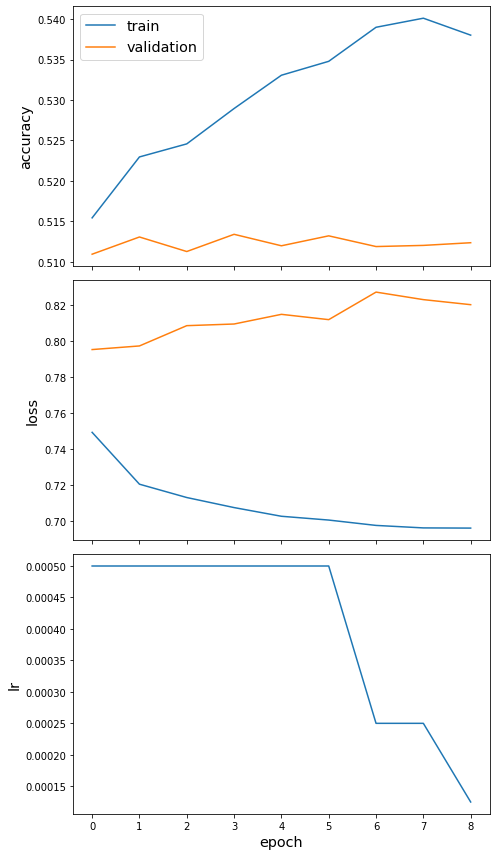

In [ ]:
sg.utils.plot_history(history)

train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


num_tests = 1  # the number of times to generate predictions

all_test_predictions = [
    model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
]

Before calibrating, we calculate the expected calibration error on the test set:

In [ ]:
calibration_data = [calibration_curve(y_prob=test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True)
    for test_predictions in all_test_predictions]


for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_pre_calibration = expected_calibration_error(
        prediction_probabilities=all_test_predictions[0],
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,)
    print("ECE: (before calibration) {:.4f}".format(ece_pre_calibration))

We will use Platt scaling to calibrate the model:

In [ ]:
num_tests = 1
score_model = keras.Model(inputs=x_inp, outputs=logits)

all_val_score_predictions = [score_model.predict(val_flow, verbose=True) for _ in np.arange(num_tests)]
all_test_score_predictions = [score_model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)]
all_test_probabilistic_predictions = [model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)]

val_predictions = np.mean(np.array(all_val_score_predictions), axis=0)

test_predictions = np.mean(np.array(all_test_score_predictions), axis=0)

# for binary classification this class performs Platt Scaling
lr = TemperatureCalibration()

lr.fit(val_predictions, edge_labels_val)

lr_test_predictions = lr.predict(test_predictions)

calibration_data = [calibration_curve(y_prob=lr_test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True)]

for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_post_calibration = expected_calibration_error(
        prediction_probabilities=lr_test_predictions,
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,)
    print("ECE (after calibration): {:.4f}".format(ece_post_calibration))

828/828 [==============================] - 389s 470ms/step
ECE (after calibration): 0.2226


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Check how the calibration improved the model:

In [ ]:
y_pred = np.zeros(len(test_predictions))

 # the true predictions are the probabilistic outputs
test_predictions = np.mean(np.array(all_test_probabilistic_predictions), axis=0)
y_pred[test_predictions.reshape(-1) > 0.5] = 1
print("Accuracy of model before calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)))

Accuracy of model before calibration: 0.77


In [ ]:
y_pred = np.zeros(len(lr_test_predictions))
y_pred[lr_test_predictions[:, 0] > 0.5] = 1
print("Accuracy for model after calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)))

Accuracy for model after calibration: 0.68
